In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [4]:
# database tables
game_info = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/game_info.csv', index_col=0)
team_stats = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/team_stats.csv', index_col=0)

# four factor data (10, 20, 30 game averages)
team_factor_10 = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/team_factor_10.csv', index_col=0)
team_factor_20 = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/team_factor_20.csv', index_col=0)
team_factor_30 = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/team_factor_30.csv', index_col=0)

# all boxscore data (10, 20, 30 game averages)
team_full_10 = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/team_full_10.csv', index_col=0)
team_full_20 = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/team_full_20.csv', index_col=0)
team_full_30 = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/team_full_30.csv', index_col=0)

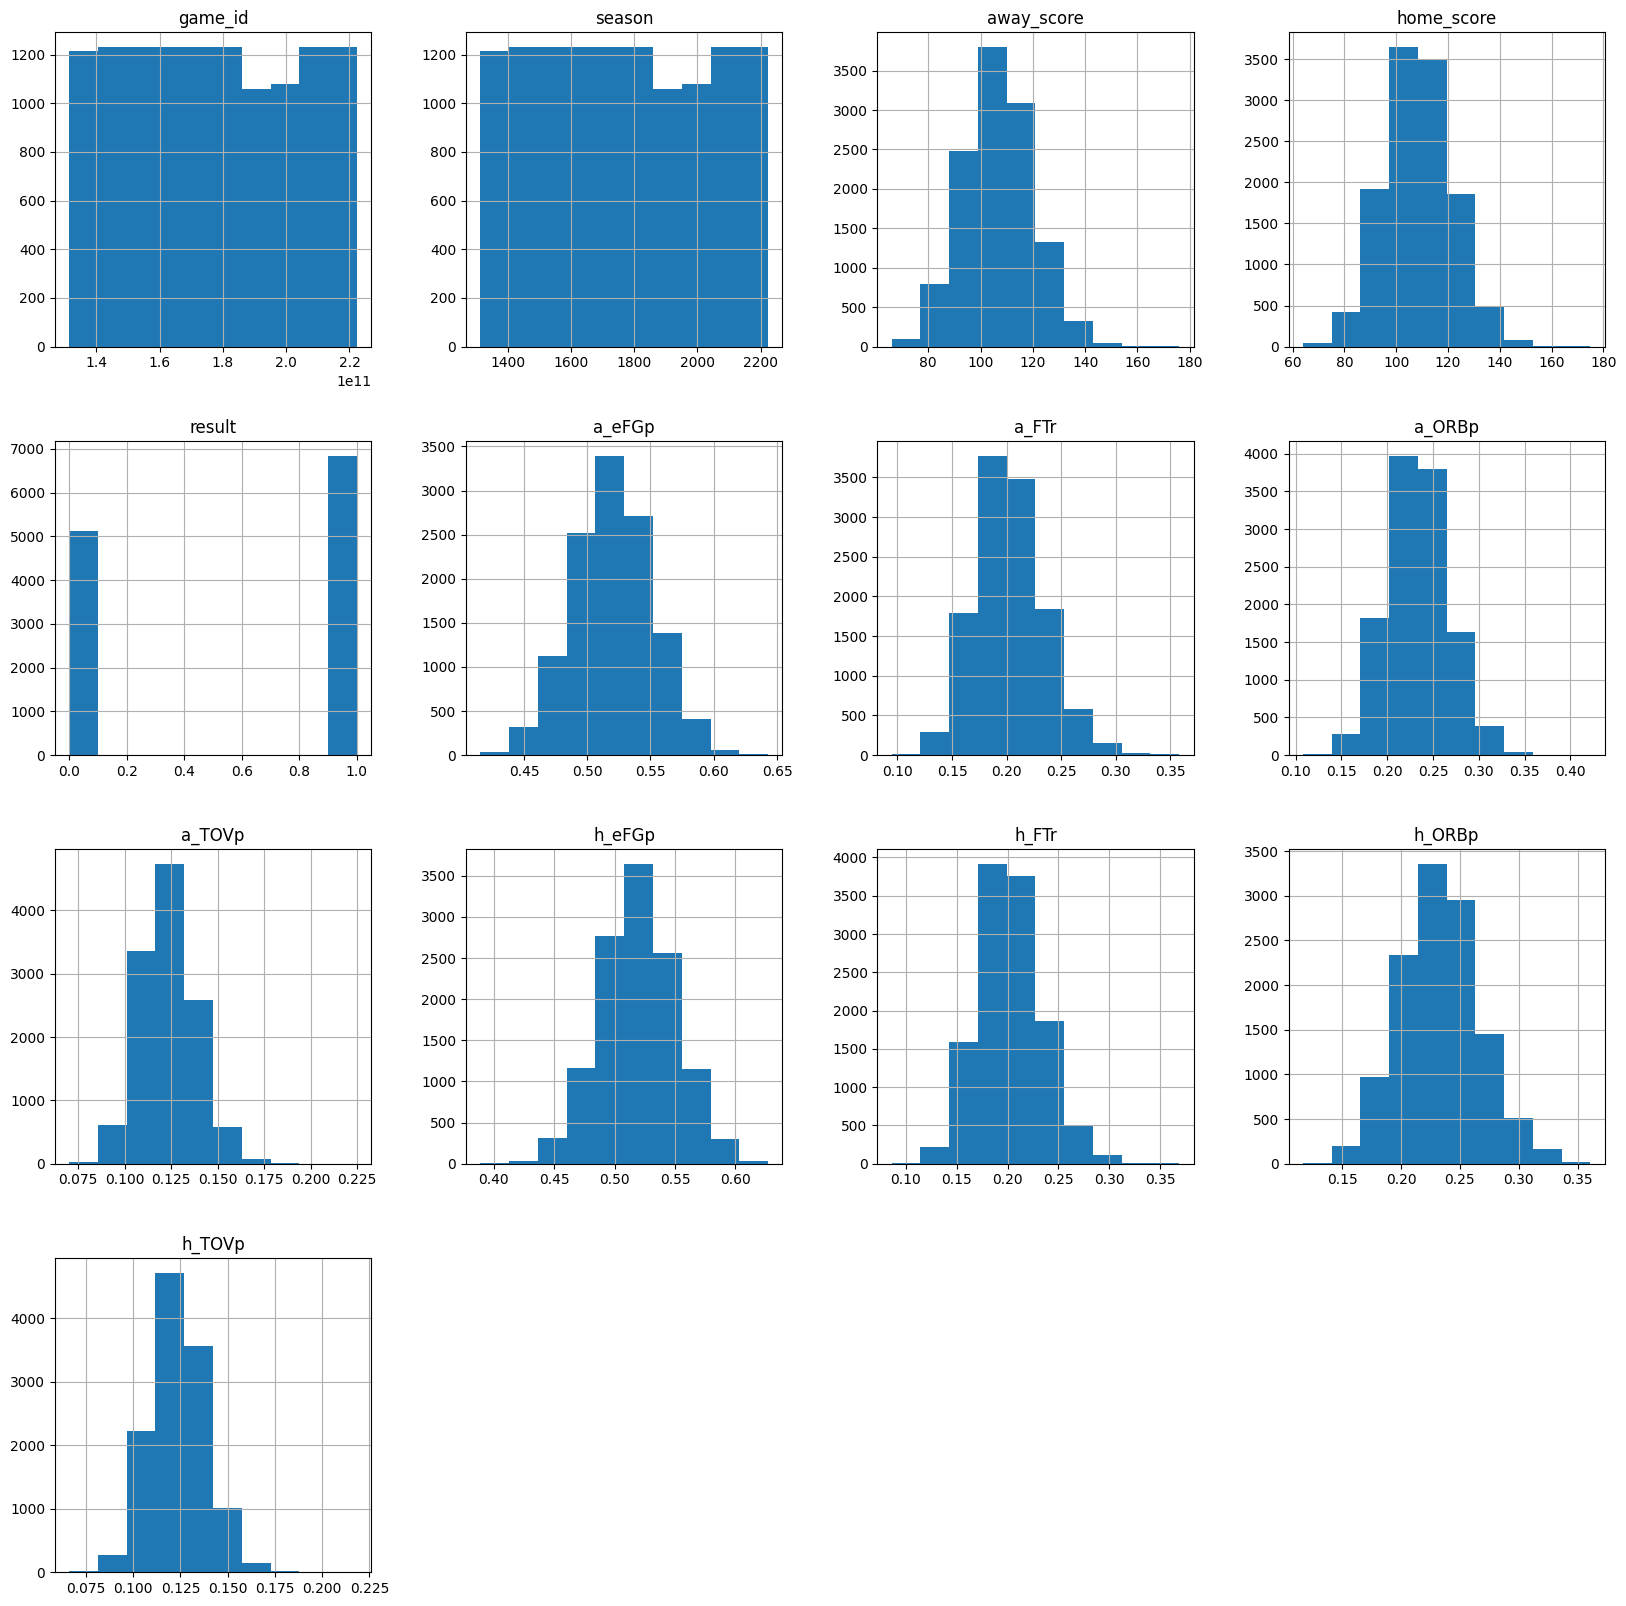

In [5]:
team_factor_10.dropna(inplace=True)
team_factor_10.reset_index(drop=True, inplace=True)
team_factor_10.hist(figsize=(20,20));

In [6]:
results_df = pd.DataFrame(columns=['model_name', 'cv_score', 'gs_score', 'train_score', 'test_score'])
residuals_df = pd.DataFrame(columns=['y_true'])
residuals_df['y_true'] = team_factor_10['result']

Aşağıdaki class çalıntı ve pipeline yapıyor

In [10]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


class ModelEval():
    '''
    A pipeline to process data, perform cross validation and grid search,
    fit model, calculate model predictions and accuracy, create confidence matrix,
    and log results.
    
    Parameters
    ----------
    model : an instantiated scikit-learn model object.
    
    model_name : a string with the model name
    
    results_df : dataframe to hold the results for each successive model
    
    residuals_df : dataframe to hold the predictions for each successive model
    
    stats : X_train, X_test, y_train, y_test from sklearn.model_selection.train_test_split
    
    param_grid : the parameter grid used in the model grid search
    
    scaler : a 'yes'/'no' string indicating whether the model requires
             scaling the data with sklearn.preprocessing.StandardScaler
    
    pca : a 'yes'/'no' string indicating whether or not to perform scaling and PCA on the data.
    '''
    
    def __init__(self, model, model_name, results_df, residuals_df, stats, param_grid, scaler='no', pca='no', n_components=None):
        
        self.model = model
        self.model_name = model_name
        self.results_df = results_df
        self.residuals_df = residuals_df
        self.X_train, self.X_test, self.y_train, self.y_test = stats
        self.param_grid = param_grid
        self.cv_score = None
        self.gs_score = None
        
        if scaler == 'yes':
            scaler = StandardScaler()
            self.X_train = scaler.fit_transform(self.X_train)
            self.X_test = scaler.transform(self.X_test)
            
        if pca == 'yes':
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(self.X_train)
            X_test_scaled = scaler.transform(self.X_test)

            pca = PCA(n_components=n_components)
            X_train_pca = pca.fit_transform(X_train_scaled)
            X_test_pca = pca.transform(X_test_scaled)
            
            self.X_train = X_train_pca
            self.X_test = X_test_pca

            self.explained_variance = sum(pca.explained_variance_ratio_)
    
    def calc_cv(self):
        
        cv_scores = cross_val_score(self.model, self.X_train, self.y_train, cv=3)
        self.cv_score = cv_scores.mean()
        self.fitted_model = self.model.fit(self.X_train, self.y_train)
    
    def calc_grid_search(self):
        
        grid_search = GridSearchCV(self.model, self.param_grid, cv=3)
        self.fitted_model = grid_search.fit(self.X_train, self.y_train)
        self.params_model = grid_search.best_estimator_
        self.gs_score = grid_search.best_score_
        
    def calc_train_preds(self):
        
        self.train_preds = self.fitted_model.predict(self.X_train)
    
    def calc_test_preds(self):
        
        self.test_preds = self.fitted_model.predict(self.X_test)
    
    def calc_train_score(self):
        
        self.train_score = self.fitted_model.score(self.X_train, self.y_train)
    
    def calc_test_score(self):
    
        self.test_score = self.fitted_model.score(self.X_test, self.y_test)
    
    def create_conf_matrix(self):
        conf_matrix = confusion_matrix(y_true=self.y_test, y_pred=self.test_preds)
        self.disp = ConfusionMatrixDisplay(conf_matrix)
        return self.disp.plot();
    
    def record_results(self):
        
        idx = self.results_df.shape[0]
        results_df.loc[idx] = [self.model_name, self.cv_score, self.gs_score, self.train_score, self.test_score]
    
    def calc_residuals(self):
        
        train_preds_df = pd.DataFrame(self.train_preds, index=self.y_train.index)
        test_preds_df = pd.DataFrame(self.test_preds, index=self.y_test.index)
        
        self.model_preds = pd.concat([train_preds_df, test_preds_df]).sort_index()
        
        self.residuals_df[f'{self.model_name}' + '_residuals'] = self.residuals_df['y_true'] - self.model_preds[0]
    
    def full_diag(self):
        
        if self.param_grid == None:   
            self.calc_cv()
        else:
            self.calc_grid_search()
            
        self.calc_train_preds()
        self.calc_test_preds()
        self.calc_train_score()
        self.calc_test_score()
        self.create_conf_matrix()
        self.record_results()
        self.calc_residuals()

# 

,model_name,cv_score,gs_score,train_score,test_score
0,log_4F_8var_10,0.598977,None,0.613503,0.589219


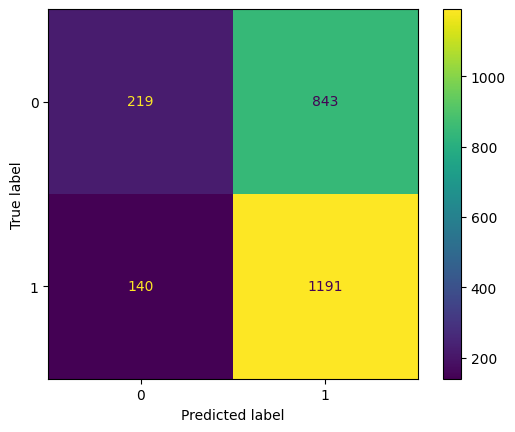

In [11]:
stat_columns = ['a_eFGp', 'a_FTr', 'a_ORBp', 'a_TOVp', 'h_eFGp', 'h_FTr', 'h_ORBp', 'h_TOVp']

X = team_factor_10[stat_columns]
y = team_factor_10['result']

stats = train_test_split(X, y, train_size=.80, random_state=31)

# instantiate model object
log = LogisticRegression(random_state=31)

# train and evaluate the model
log_model = ModelEval(log, 'log_4F_8var_10', results_df, residuals_df, stats, None)
log_model.full_diag()

results_df

In [13]:
# combine away and home stats
team_factor_10['eFGp'] = team_factor_10['a_eFGp'] - team_factor_10['h_eFGp']
team_factor_10['FTr'] = team_factor_10['a_FTr'] - team_factor_10['h_FTr']
team_factor_10['ORBp'] = team_factor_10['a_ORBp'] - team_factor_10['h_ORBp']
team_factor_10['TOVp'] = team_factor_10['a_TOVp'] - team_factor_10['h_TOVp']

stat_columns = ['eFGp', 'FTr', 'ORBp', 'TOVp']

X = team_factor_10[stat_columns]
y = team_factor_10['result']

stats = train_test_split(X, y, train_size=.80, random_state=31)

# Logial Regression Model for NBA

/Users/mertcansaglam/Cs452_project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/mertcansaglam/Cs452_project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/mertcansaglam/Cs452_project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/mertcansaglam/Cs452_project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/mertcansaglam/Cs452_project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warni

,model_name,cv_score,gs_score,train_score,test_score
0,log_4F_8var_10,0.598977,NaN,0.613503,0.589219
1,log_gs_4F_10,NaN,0.621761,0.620715,0.601337


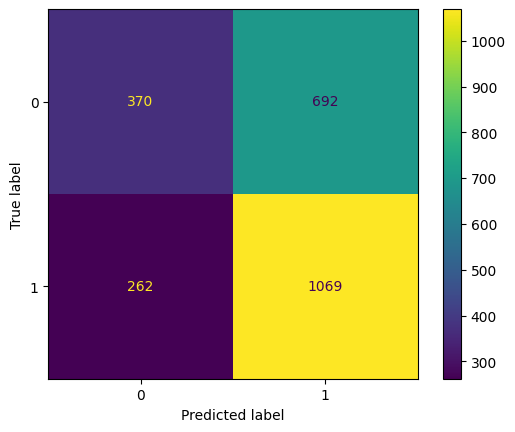

In [15]:
log_gs = LogisticRegression(solver='saga', random_state=31)
log_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 1.0,],
}

log_gs_model = ModelEval(log_gs, 'log_gs_4F_10', results_df, residuals_df, stats, log_param_grid, scaler='yes')
log_gs_model.full_diag()

results_df